# Import libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import Imputer

from scipy.stats import skew

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

# Import data

In [2]:
train = 'train.csv'
test = 'test.csv'

df_train = pd.read_csv(train)
df_test = pd.read_csv(test)

# Define Median Absolute Deviation Function

Function found in this link: http://stackoverflow.com/a/22357811/5082694

In [3]:
def is_outlier(points, thresh = 3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

# Remove Skew from SalesPrice data

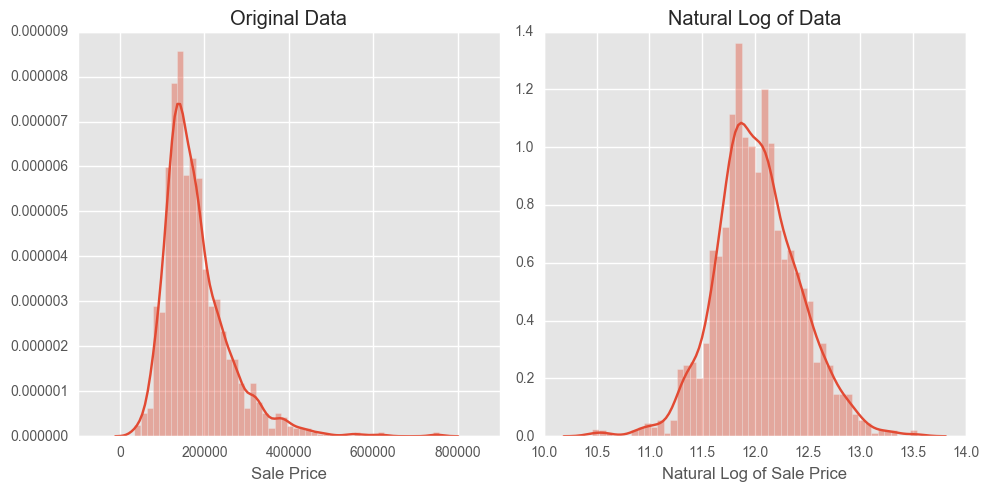

In [4]:
target = df_train[df_train.columns.values[-1]]
target_log = np.log(target)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.distplot(target, bins=50)
plt.title('Original Data')
plt.xlabel('Sale Price')

plt.subplot(1,2,2)
sns.distplot(target_log, bins=50)
plt.title('Natural Log of Data')
plt.xlabel('Natural Log of Sale Price')
plt.tight_layout()

# Merge Train and Test to evaluate ranges and missing values

In [5]:
df_train = df_train[df_train.columns.values[:-1]]
df = df_train.append(df_test, ignore_index = True)

# Find all categorical data

In [6]:
cats = []
for col in df.columns.values:
    if df[col].dtype == 'object':
        cats.append(col)

# Create separte datasets for Continuous vs Categorical

Creating two data sets allowed me to handle the data in more appropriate ways.

In [7]:
df_cont = df.drop(cats, axis=1)
df_cat = df[cats]

# Handle Missing Data for continuous data

- If any column contains more than 50 entries of missing data, drop the column
- If any column contains fewer that 50 entries of missing data, replace those missing values with the median for that column
- Remove outliers using Median Absolute Deviation
- Calculate skewness for each variable and if greater than 0.75 transform it
- Apply the sklearn.Normalizer to each column

In [8]:
for col in df_cont.columns.values:
    if np.sum(df_cont[col].isnull()) > 50:
        df_cont = df_cont.drop(col, axis = 1)
    elif np.sum(df_cont[col].isnull()) > 0:
        median = df_cont[col].median()
        idx = np.where(df_cont[col].isnull())[0]
        df_cont[col].iloc[idx] = median

        outliers = np.where(is_outlier(df_cont[col]))
        df_cont[col].iloc[outliers] = median
        
        if skew(df_cont[col]) > 0.75:
            df_cont[col] = np.log(df_cont[col])
            df_cont[col] = df_cont[col].apply(lambda x: 0 if x == -np.inf else x)
        
        df_cont[col] = Normalizer().fit_transform(df_cont[col].reshape(1,-1))[0]

/Users/nvanuden/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


# Handle Missing Data for Categorical Data

- If any column contains more than 50 entries of missing data, drop the column
- If any column contains fewer that 50 entries of missing data, replace those values with the 'MIA'
- Apply the sklearn.LabelEncoder
- For each categorical variable determine the number of unique values and for each, create a new column that is binary

In [9]:
for col in df_cat.columns.values:
    if np.sum(df_cat[col].isnull()) > 50:
        df_cat = df_cat.drop(col, axis = 1)
        continue
    elif np.sum(df_cat[col].isnull()) > 0:
        df_cat[col] = df_cat[col].fillna('MIA')
        
    df_cat[col] = LabelEncoder().fit_transform(df_cat[col])
    
    num_cols = df_cat[col].max()
    for i in range(num_cols):
        col_name = col + '_' + str(i)
        df_cat[col_name] = df_cat[col].apply(lambda x: 1 if x == i else 0)
        
    df_cat = df_cat.drop(col, axis = 1)

/Users/nvanuden/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/nvanuden/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/nvanuden/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

# Merge Numeric and Categorical Datasets and Create Training and Testing Data

In [10]:
df_new = df_cont.join(df_cat)

df_train = df_new.iloc[:len(df_train) - 1]
df_train = df_train.join(target_log)

df_test = df_new.iloc[len(df_train) + 1:]

X_train = df_train[df_train.columns.values[1:-1]]
y_train = df_train[df_train.columns.values[-1]]

X_test = df_test[df_test.columns.values[1:]]

# Create Estimator and Apply Cross Validation

We can gauge the accuracy of our model by implementing an multi-fold cross validation and outputting the score. In this case I chose to run 15 iterations and output the score as Root Mean Squared Error.

The results range from ~0.11-0.17 with a mean of ~0.14.

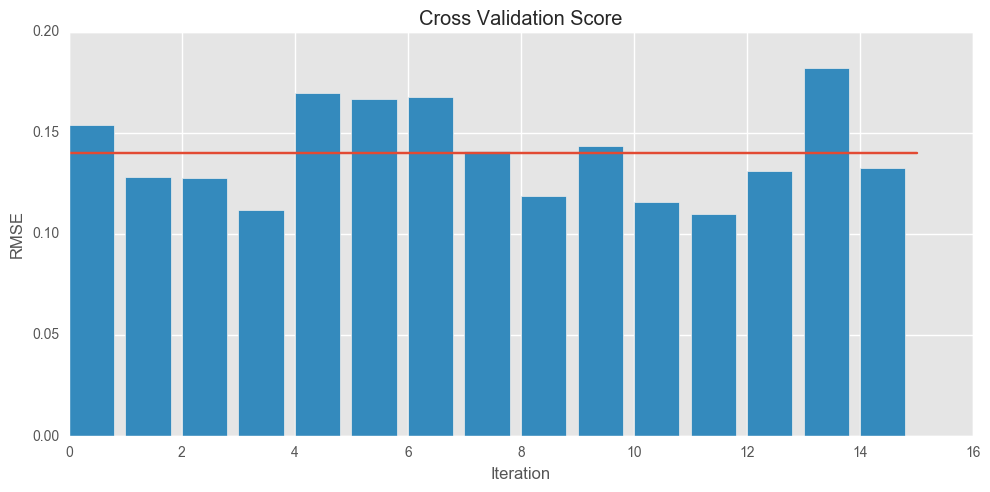

In [13]:
from sklearn.metrics import make_scorer, mean_squared_error
scorer = make_scorer(mean_squared_error, False)

clf = RandomForestRegressor(n_estimators=500, n_jobs=-1)
cv_score = np.sqrt(-cross_val_score(estimator=clf, X=X_train, y=y_train, cv=15, scoring = scorer))

plt.figure(figsize=(10,5))
plt.bar(range(len(cv_score)), cv_score)
plt.title('Cross Validation Score')
plt.ylabel('RMSE')
plt.xlabel('Iteration')

plt.plot(range(len(cv_score) + 1), [cv_score.mean()] * (len(cv_score) + 1))
plt.tight_layout()

# Evaluate Feature Significance

Investigating feature importance is a relatively straight forward process:
1. Out feature importance coefficients
2. Map coefficients to their feature name
3. Sort features in descending order

Given our choice of model and methods for preprocessing data the most significant features are:
1. OverallQual
2. GrLivArea
3. TotalBsmtSF
4. GarageArea

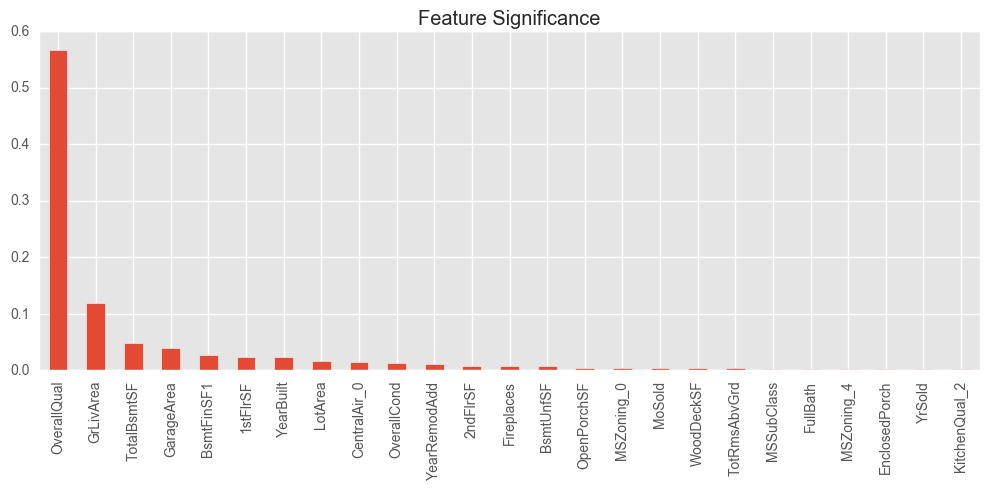

In [14]:
# Fit model with training data
clf.fit(X_train, y_train)

# Output feature importance coefficients, map them to their feature name, and sort values
coef = pd.Series(clf.feature_importances_, index = X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
coef.head(25).plot(kind='bar')
plt.title('Feature Significance')
plt.tight_layout()

# Visualize Predicted vs. Actual Sales Price

In order to visualize our predicted values vs our actual values we need to split our data into training and testing data sets. This can easily be accomplished using sklearn's train_test_split module.

We will train the model using a random sampling of our data set and then compare visually against the actual values.

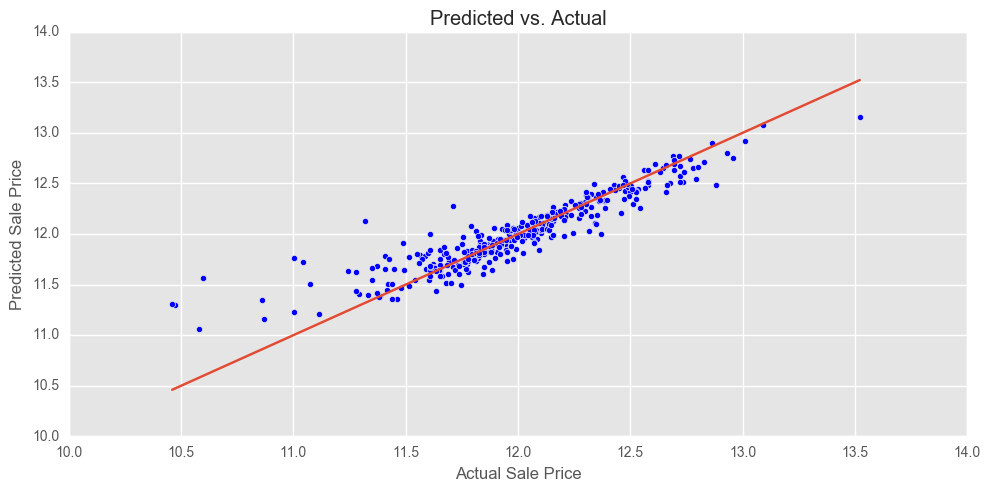

In [15]:
from sklearn.cross_validation import train_test_split

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train)
clf = RandomForestRegressor(n_estimators=500, n_jobs=-1)

clf.fit(X_train1, y_train1)
y_pred = clf.predict(X_test1)

plt.figure(figsize=(10, 5))
plt.scatter(y_test1, y_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_test1), max(y_test1)], [min(y_test1), max(y_test1)])
plt.tight_layout()